# Extra point 1: Sentiment Analysis with Doc2Vec

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from shutil import copyfile
import zipfile
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from scipy.stats import norm, probplot
import plotly.express as px
import plotly.figure_factory as ff

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
source_path = "/content/drive/MyDrive/marketing analytics/file aggiornati.zip"

In [ ]:
# Extract file: tbl_customer_review
t0 = time()
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('tbl_labelled_reviews.csv')
print("File extraction completed in %0.3f seconds" % (time() - t0))

File extraction completed in 6.501 seconds


In [ ]:
# File path of the extracted 'tbl_customers.csv' file
csv_file_path = "tbl_labelled_reviews.csv"
tbl_labelled_reviews = pd.read_csv(csv_file_path)

In [ ]:
tbl_labelled_reviews.head()

,Unnamed: 0,labelled_reviews_index,review_text,sentiment_label
0,0,0,I'm no bitters expert but I bought it as a gif...,neutral
1,1,1,"these are probably great in the right drinks, ...",neutral
2,2,2,I sent these to my dad for his bday and he sai...,positive
3,3,3,I purchased these as a gift for family member ...,positive
4,4,4,My wife bought me this sauce sampler for Chris...,neutral


### Preprocessing
In the next lines of code we apply the same preprocessing operations (stopwords, tags, and punctuation removal, sentiment label mapping and class balancing) used in the sentiment analysis involving BERT

In [ ]:
# We apply the same function used in the sentiment analysis in order to remove stopwords and other elements in the reviews

def custom_standardization(input_data):
    # Convert to lowercase
    lowercase = input_data.lower()

    # Remove URLs
    without_urls = re.sub(r'http\S+', ' ', lowercase)

    # Remove HTML tags like "<br />"
    stripped_html = re.sub("<br\s*/?>", " ", without_urls)


    # Remove punctuation
    punctuation_regex = f"[{re.escape(string.punctuation)}]"
    cleaned_text = re.sub(punctuation_regex, "", stripped_html)
    # Remove numbers
    cleaned_text = re.sub(r'\d+', '', cleaned_text)

    # Remove sequences containing digits and word characters
    cleaned_text = re.sub(r'\w*\d\w*', '', cleaned_text)

    return cleaned_text

# Assuming "review_text" is the column containing the review text
tbl_labelled_reviews['review_text_cleaned'] = tbl_labelled_reviews['review_text'].apply(custom_standardization)
# Remove stop words for each review_text_cleaned
stop = stopwords.words('english')


tbl_labelled_reviews['review_text_cleaned'] = tbl_labelled_reviews['review_text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
# Define a dictionary to map sentiment labels to numeric values
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}

# Apply the mapping to the 'sentiment_label' column
tbl_labelled_reviews['numeric_sentiment'] = tbl_labelled_reviews['sentiment_label'].map(sentiment_mapping)

# We drop the columns 'Unnamed: 0', 'sentiment_label','review_text'
tbl_labelled_reviews.drop(['Unnamed: 0', 'sentiment_label','review_text'], axis=1, inplace=True)

In [ ]:
tbl_labelled_reviews.head()

,labelled_reviews_index,review_text_cleaned,numeric_sentiment
0,0,im bitters expert bought gift friend surprised...,1
1,1,probably great right drinks dont like old fash...,1
2,2,sent dad bday said really pretty good hes hard...,2
3,3,purchased gift family member loves bbq pork wa...,2
4,4,wife bought sauce sampler christmas knowing lo...,1


In [ ]:
tbl_labelled_reviews.columns

Index(['labelled_reviews_index', 'review_text_cleaned', 'numeric_sentiment'], dtype='object')

In [ ]:
# Shuffle the DataFrame
tbl_labelled_reviews = tbl_labelled_reviews.sample(frac=1)

#  Separate DataFrame for each sentiment label
df_negative = tbl_labelled_reviews[tbl_labelled_reviews['numeric_sentiment'] == 0]
df_neutral = tbl_labelled_reviews[tbl_labelled_reviews['numeric_sentiment'] == 1]
df_positive = tbl_labelled_reviews[tbl_labelled_reviews['numeric_sentiment'] == 2]

# Calculate the number of rows for the train and test sets
train_ratio = 0.8
test_ratio = 0.2

num_train_negative = int(len(df_negative) * train_ratio)
num_train_neutral = int(len(df_neutral) * train_ratio)
num_train_positive = int(len(df_positive) * train_ratio)

# Combine to create train and test sets
train_set = pd.concat([
    df_negative[:num_train_negative],
    df_neutral[:num_train_neutral],
    df_positive[:num_train_positive]
])

val_set = pd.concat([
    df_negative[num_train_negative:],
    df_neutral[num_train_neutral:],
    df_positive[num_train_positive:]
])

# Shuffle the train and test sets
train_set = train_set.sample(frac=1)
val_set = val_set.sample(frac=1)

#train dataset
train_ds=train_set.review_text_cleaned

#test dataset
val_ds=val_set.review_text_cleaned

In [ ]:
train_ds

369539    favorite coffee starbucks caramel macchiato lo...
198304    truly temptations cats running side house open...
53180     almonds tastes right since dry salt hardly sta...
427468    absolutely love give day snack fabulous loved ...
187763    delicious dangerous purchase limiting bar day ...
                                ...                        
284956    switched dog food watching truly enjoy eating ...
124967    want energy drink tastes good stuff tastes lik...
339854    peanut butter cookies good packages cookies br...
322451    pack jarred strained tomatoes took two weeks a...
127661    buy gloria jeans hazelnut kcups pack came case...
Name: review_text_cleaned, Length: 370194, dtype: object

In [ ]:
#one-hot-encoding
from sklearn.preprocessing import OneHotEncoder

train_label=train_set.numeric_sentiment
val_label=val_set.numeric_sentiment

# Apply one-hot encoding to labels
ohe = OneHotEncoder()
train_label_encoded = ohe.fit_transform(np.array(train_label).reshape(-1, 1)).toarray()
val_label_encoded = ohe.transform(np.array(val_label).reshape(-1, 1)).toarray()

print("train_label sample:")
print(train_label[:10])

print("val_label sample:")
print(val_label[:10])

train_label sample:
369539    2
198304    2
53180     2
427468    2
187763    2
111612    2
3159      2
357096    2
393333    2
209308    2
Name: numeric_sentiment, dtype: int64
val_label sample:
422146    1
461330    2
460342    2
348082    2
448115    1
17507     2
16494     2
150213    2
418382    1
357911    1
Name: numeric_sentiment, dtype: int64


In [ ]:
# Converting train_ds array to dataframe for better usability

train_df = pd.DataFrame(data=train_ds, columns=['review_text_cleaned'])
train_df.head()

,review_text_cleaned
369539,favorite coffee starbucks caramel macchiato lo...
198304,truly temptations cats running side house open...
53180,almonds tastes right since dry salt hardly sta...
427468,absolutely love give day snack fabulous loved ...
187763,delicious dangerous purchase limiting bar day ...


In [ ]:
# Converting val_ds array to dataframe for better usability

val_df = pd.DataFrame(data=val_ds, columns=['review_text_cleaned'])
val_df.head()

,review_text_cleaned
422146,cant weigh original version product never trie...
461330,makes delicious cappuccino especially paired b...
460342,find picky eater gets nutrients nextstep hard ...
348082,favourite coffee last time couldnt find store ...
448115,premium coffee nice roasty edge good body litt...


In [ ]:
# Converting train_label array to dataframe for better usability

train_label_df = pd.DataFrame(data=train_label, columns=['numeric_sentiment'])
train_label_df.head()

,numeric_sentiment
369539,2
198304,2
53180,2
427468,2
187763,2


In [ ]:
# Converting val_label array to dataframe for better usability

val_label_df = pd.DataFrame(data=val_label, columns=['numeric_sentiment'])
val_label_df.head()

,numeric_sentiment
422146,1
461330,2
460342,2
348082,2
448115,1


In [ ]:
# Merging train dataframes

merged_train_df = pd.merge(train_df, train_label_df, left_index=True, right_index=True)
merged_train_df.head()

,review_text_cleaned,numeric_sentiment
369539,favorite coffee starbucks caramel macchiato lo...,2
198304,truly temptations cats running side house open...,2
53180,almonds tastes right since dry salt hardly sta...,2
427468,absolutely love give day snack fabulous loved ...,2
187763,delicious dangerous purchase limiting bar day ...,2


In [ ]:
# Merging validation dataframes

merged_val_df = pd.merge(val_df, val_label_df, left_index=True, right_index=True)
merged_val_df.head()

,review_text_cleaned,numeric_sentiment
422146,cant weigh original version product never trie...,1
461330,makes delicious cappuccino especially paired b...,2
460342,find picky eater gets nutrients nextstep hard ...,2
348082,favourite coffee last time couldnt find store ...,2
448115,premium coffee nice roasty edge good body litt...,1


# Doc2Vec Model Training

Doc2Vec is an extension of Word2Vec, a popular natural language processing technique. Unlike Word2Vec, which learns vector representations for individual words, Doc2Vec extends this concept to learn representations for entire documents, allowing it to capture semantic relationships between documents in addition to words. It's a powerful tool for tasks like document similarity, sentiment analysis, and content recommendation.

In [ ]:
# Modules importing

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Text tokenization

def tokenize_text(text):
    tokens = word_tokenize(text)

    return tokens

# Tagged documents creation for training fase
train_documents = [TaggedDocument(words=tokenize_text(text), tags=[str(i)]) for i, text in enumerate(merged_train_df['review_text_cleaned'])]

In [ ]:
# Model training

model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=10)
model.build_vocab(train_documents)
model.train(train_documents, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
# Making prediction on validation set

test_documents = [tokenize_text(text) for text in merged_val_df['review_text_cleaned']]
predictions = [model.infer_vector(doc) for doc in test_documents]

In [ ]:
# Model performance evaluation

true_labels = merged_val_df['numeric_sentiment'].tolist()
true_labels = np.array(true_labels).reshape(-1, 1)
true_labels.shape

(92550, 1)

In [ ]:
clf = LogisticRegression(random_state=0)
clf.fit(predictions, true_labels)

# Making predictions
predictions = clf.predict(predictions)

# Model evaluation
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions)

print(f"Accuracy: {accuracy}")
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7018908698001081
              precision    recall  f1-score   support

           0       0.55      0.24      0.34      8470
           1       0.59      0.31      0.40     24678
           2       0.73      0.93      0.82     59402

    accuracy                           0.70     92550
   macro avg       0.62      0.49      0.52     92550
weighted avg       0.68      0.70      0.66     92550



## Prediction on new data: "tbl_costumer_reviews"

In [ ]:
# Extract file: tbl_customer_review
t0 = time()
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('tbl_customer_reviews.csv')
print("File extraction completed in %0.3f seconds" % (time() - t0))

File extraction completed in 0.865 seconds


In [ ]:
# File path of the extracted 'tbl_customers.csv' file
csv_file_path = "tbl_customer_reviews.csv"
tbl_customer_reviews = pd.read_csv(csv_file_path)

In [ ]:
tbl_customer_reviews

,Unnamed: 0,review_id,customer_id,review_text,review_text_cleaned,sentiment_of_review
0,0,1,814256,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,2
1,1,2,457475,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,1
2,2,3,104045,This is a confection that has been around a fe...,confection around centuries light pillowy citr...,2
3,3,4,603662,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,1
4,4,5,739314,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,2
...,...,...,...,...,...,...
105705,105705,140942,224091,"We Love,Love our Keurig coffee maker .My husba...",lovelove keurig coffee maker husband lives bre...,2
105706,105706,140943,196666,This is supposed to be a light roast coffee bu...,supposed light roast coffee states extra bold ...,0
105707,105707,140944,618226,I have always been happy with my Kcups but thi...,always happy kcups particular box good made cu...,0
105708,105708,140945,844918,I ordered light roast coffee and was sent one ...,ordered light roast coffee sent one box light ...,1


In [ ]:
# Assuming "review_text" is the column containing the review text
tbl_customer_reviews['review_text_cleaned'] = tbl_customer_reviews['review_text'].apply(custom_standardization)
# Remove stop words for each review_text_cleaned
stop = stopwords.words('english')

tbl_customer_reviews['review_text_cleaned'] = tbl_customer_reviews['review_text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
tbl_customer_reviews

,Unnamed: 0,review_id,customer_id,review_text,review_text_cleaned,sentiment_of_review
0,0,1,814256,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,2
1,1,2,457475,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,1
2,2,3,104045,This is a confection that has been around a fe...,confection around centuries light pillowy citr...,2
3,3,4,603662,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,1
4,4,5,739314,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,2
...,...,...,...,...,...,...
105705,105705,140942,224091,"We Love,Love our Keurig coffee maker .My husba...",lovelove keurig coffee maker husband lives bre...,2
105706,105706,140943,196666,This is supposed to be a light roast coffee bu...,supposed light roast coffee states extra bold ...,0
105707,105707,140944,618226,I have always been happy with my Kcups but thi...,always happy kcups particular box good made cu...,0
105708,105708,140945,844918,I ordered light roast coffee and was sent one ...,ordered light roast coffee sent one box light ...,1


In [ ]:
tbl_customer_reviews['review_text_cleaned'] = tbl_customer_reviews['review_text_cleaned'].astype(str)
tbl_customer_reviews.review_text_cleaned.dtype

dtype('O')

In [ ]:
# Tokenization

tbl_customer_reviews['tokenized_text'] = tbl_customer_reviews['review_text_cleaned'].apply(lambda x: word_tokenize(x))

In [ ]:
# Function to obtain Doc2Vec vectors from tokens
def get_doc2vec_vectors(tokens):
    return model.infer_vector(tokens)

# Applying the function to the 'tokenized_text' column and saving the results in a new column
tbl_customer_reviews['doc2vec_vectors'] = tbl_customer_reviews['tokenized_text'].apply(get_doc2vec_vectors)

In [ ]:
# Utilizing vectors as input
X_prediction = np.vstack(tbl_customer_reviews['doc2vec_vectors'].values)

# Making prediction using the classification model
predictions_cs = clf.predict(X_prediction)

# Adding a new column to the dataframe
tbl_customer_reviews['predictions'] = predictions_cs

In [ ]:
tbl_customer_reviews

,Unnamed: 0,review_id,customer_id,review_text,review_text_cleaned,sentiment_of_review,tokenized_text,doc2vec_vectors,predictions
0,0,1,814256,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,2,"[bought, several, vitality, canned, dog, food,...","[-0.09351985, -0.014430162, -0.11726735, 0.099...",2
1,1,2,457475,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,1,"[product, arrived, labeled, jumbo, salted, pea...","[0.0759919, -0.056707785, 0.0068074157, 0.1099...",1
2,2,3,104045,This is a confection that has been around a fe...,confection around centuries light pillowy citr...,2,"[confection, around, centuries, light, pillowy...","[-0.0788051, 0.20792952, 0.103532866, 0.121960...",2
3,3,4,603662,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,1,"[looking, secret, ingredient, robitussin, beli...","[0.1036389, -0.066388614, -0.0786261, 0.022921...",2
4,4,5,739314,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,2,"[great, taffy, great, price, wide, assortment,...","[-0.031567574, 0.087092504, 0.0689935, 0.03920...",2
...,...,...,...,...,...,...,...,...,...
105705,105705,140942,224091,"We Love,Love our Keurig coffee maker .My husba...",lovelove keurig coffee maker husband lives bre...,2,"[lovelove, keurig, coffee, maker, husband, liv...","[-0.047760677, -0.08078864, 0.13397287, 0.0383...",2
105706,105706,140943,196666,This is supposed to be a light roast coffee bu...,supposed light roast coffee states extra bold ...,0,"[supposed, light, roast, coffee, states, extra...","[0.07501185, -0.03751648, 0.011142324, 0.07768...",0
105707,105707,140944,618226,I have always been happy with my Kcups but thi...,always happy kcups particular box good made cu...,0,"[always, happy, kcups, particular, box, good, ...","[-0.020755986, -0.040848613, 0.050103024, 0.00...",2
105708,105708,140945,844918,I ordered light roast coffee and was sent one ...,ordered light roast coffee sent one box light ...,1,"[ordered, light, roast, coffee, sent, one, box...","[0.19871643, -0.12401591, -0.11271165, 0.17609...",1


In [ ]:
final_reviews = tbl_customer_reviews[['customer_id','review_text_cleaned','sentiment_of_review','predictions']].copy()
final_reviews

,customer_id,review_text_cleaned,sentiment_of_review,predictions
0,814256,bought several vitality canned dog food produc...,2,2
1,457475,product arrived labeled jumbo salted peanutsth...,1,1
2,104045,confection around centuries light pillowy citr...,2,2
3,603662,looking secret ingredient robitussin believe f...,1,2
4,739314,great taffy great price wide assortment yummy ...,2,2
...,...,...,...,...
105705,224091,lovelove keurig coffee maker husband lives bre...,2,2
105706,196666,supposed light roast coffee states extra bold ...,0,0
105707,618226,always happy kcups particular box good made cu...,0,2
105708,844918,ordered light roast coffee sent one box light ...,1,1


In [ ]:
sent_count= final_reviews.groupby('predictions', as_index=False)['customer_id'].count()
sent_count

,predictions,customer_id
0,0,4248
1,1,15562
2,2,85900


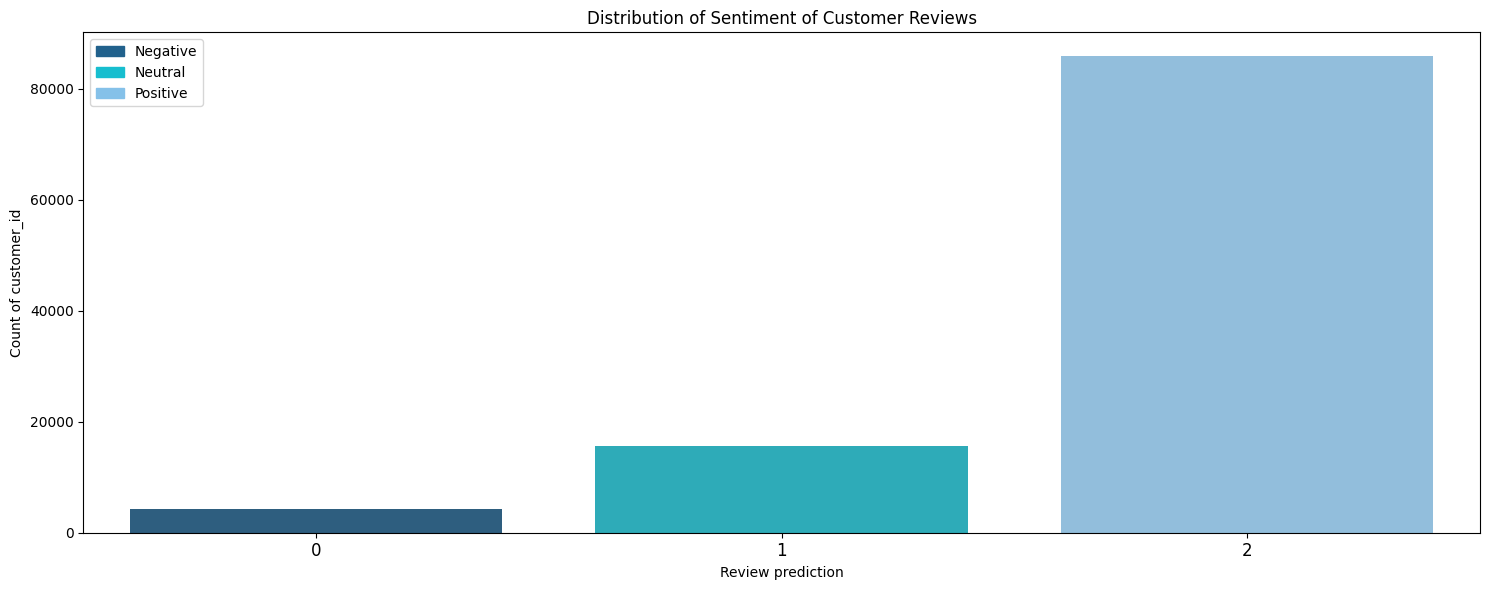

In [ ]:
# Set the figure size
plt.figure(figsize=(15, 6))

# Define a custom color palette for the sentiments
colors = ['#21618C', '#17becf', '#85C1E9']

# Create the bar plot using Seaborn with the custom color palette
ax = sns.barplot(data=sent_count, x='predictions', y='customer_id', palette=colors)

# Customize the plot
plt.xlabel('Review prediction')
plt.ylabel('Count of customer_id')
plt.title('Distribution of Sentiment of Customer Reviews')
plt.xticks(fontsize=12)

# Define the legend labels and handles
legend_labels = ['Negative', 'Neutral', 'Positive']
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], label=label) for i, label in enumerate(legend_labels)]

# Add a legend with labels
ax.legend(handles=handles, labels=legend_labels)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Model evaluation

colonna1 = final_reviews['sentiment_of_review']
colonna2 = final_reviews['predictions']

accuracy = accuracy_score(colonna1, colonna2)
report = classification_report(colonna1, colonna2)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.7425598335067638
              precision    recall  f1-score   support

           0       0.60      0.27      0.37      9490
           1       0.57      0.37      0.45     23849
           2       0.78      0.93      0.85     72371

    accuracy                           0.74    105710
   macro avg       0.65      0.52      0.56    105710
weighted avg       0.72      0.74      0.72    105710



# Extra point 2

In [ ]:
#csv_file_name = 'RFM.csv'
csv_file_path = f'/content/drive/MyDrive/marketing analytics/RFM.csv'
RFM = pd.read_csv(csv_file_path)
RFM = RFM.drop(columns='Unnamed: 0')

In [ ]:
csv_file_path_2 = f'/content/drive/MyDrive/marketing analytics/rules.csv'
rules = pd.read_csv(csv_file_path_2)
rules = rules.drop(columns='Unnamed: 0')

In [ ]:
source_path = "/content/drive/MyDrive/marketing analytics/merged dataset.zip"
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('dataset.csv')

dataset = pd.read_csv("dataset.csv")
dataset = dataset.drop(columns='Unnamed: 0')

# Resolution

## Data preparation

1.   From the RFM table, I consider only customers with a diamond  class, from which I extract the top 5 purchased products along with their purchase frequency.




In [ ]:
# I filter RFM dataset considering just diamond customers
diamond = RFM[RFM['RFM_classes'] == 'Diamond']
diamond = diamond.drop(columns='RFM_classes')
diamond

,customer_id,customer_base,Monetary_Value,Frequency,Recency,frequency_score,recency_score,monetary_score,customer_loyalty
0,23,Active,483.13,7,69,High,Medium,High,Top
3,48,Active,1585.28,15,0,High,Low,High,Top
16,231,Active,642.04,12,10,High,Low,High,Top
18,253,Active,228.08,5,123,High,Medium,High,Top
19,260,Active,402.20,3,36,High,Low,High,Top
...,...,...,...,...,...,...,...,...,...
63309,922717,Active,442.21,5,0,High,Low,High,Top
63321,923626,Active,230.67,5,0,High,Low,High,Top
63323,923741,Active,773.89,3,3,High,Low,High,Top
63341,925761,Active,222.31,6,1,High,Low,High,Top


In [ ]:
diamond_full = pd.merge(diamond, dataset, on="customer_id", how="left")

In [ ]:
diamond_products = diamond_full.groupby(["customer_id", "product_id"]).size().reset_index(name="frequency")
top_5_products = diamond_products.groupby("customer_id").apply(lambda group: group.nlargest(5, "frequency")).reset_index(drop=True)
top_5_products

,customer_id,product_id,frequency
0,23,33794292,2
1,23,33795776,2
2,23,34663923,2
3,23,36604596,2
4,23,30344384,1
...,...,...,...
67432,925761,35881986,2
67433,926183,35498295,2
67434,926183,34798386,1
67435,926183,36268554,1



2.   Now I consider the rules table obtained with MBA and I merge that dataframe with the one obtained before, when the product purchased by a Diamond customer corresponds to an antecedent in the rules table

In [ ]:
# I have to convert the columns that we want to merge on in string types
rules['antecedents'] = rules['antecedents'].astype(str)
top_5_products['product_id'] = top_5_products['product_id'].astype(str)

merged_data = pd.merge(rules, top_5_products, left_on='antecedents', right_on='product_id', how='inner')
merged_data.columns

Index(['antecedents', 'consequents', 'antecedent support',
       'consequent support', 'support', 'confidence', 'lift', 'leverage',
       'conviction', 'zhangs_metric', 'customer_id', 'product_id',
       'frequency'],
      dtype='object')

In [ ]:
rfm_mba = merged_data[['customer_id','antecedents','frequency', 'consequents']]
rfm_mba = rfm_mba[rfm_mba['frequency'] > 1] # I exclude the products bought only once
rfm_mba = rfm_mba.sort_values(by='frequency', ascending=False)
rfm_mba

,customer_id,antecedents,frequency,consequents
30004,111388,33700716,19,32079103
30539,255502,33700716,16,32079103
31837,526586,33700716,14,32079103
30628,280767,33700716,14,32079103
31855,530265,33700716,14,32079103
...,...,...,...,...
6421,469202,32079103,2,32078795
17557,636964,32078935,2,"32078795, 32079103"
6414,448942,32079103,2,32078795
6413,443963,32079103,2,32078795


## Strategy definition and implementation

The strategy we decided to develop is to offer Diamond customers a discount on items that are generally subsequent to the items they purchase most frequently. However, the discount will not be the same for everyone and every product, but it will be proportional to the purchase frequency: the more a particular preceding product is purchased, the greater the discount on the subsequent ones. The purpose of the strategy is to encourage Diamond customers, who are already inclined to buy the preceding item, to make an additional purchase on the subsequent item, which is generally subsequent in terms but not necessarily for that specific customer. Obviously, the discount will be temporary: the belief is that once the customer acquires the habit of also buying the item subsequent to the preceding one, they will not give it up even if the discount no longer entices them.

In [ ]:
# Thus I calculate the percentiles that mark the change in the discount amount
percentile_90 = rfm_mba['frequency'].quantile(0.9)
percentile_50 = rfm_mba['frequency'].quantile(0.5)
percentile_90, percentile_50

(4.0, 2.0)

In [ ]:
# Subsequently, I define the function that associates a corresponding discount with each frequency range, which will obviously increase as the frequency increases
def computing_discount(frequency):
    if frequency > percentile_90:
        return 0.50
    else:
        if frequency > percentile_50:
          return 0.20
        else:
          return 0.10

rfm_mba['discount'] = rfm_mba['frequency'].apply(computing_discount)
rfm_mba

,customer_id,antecedents,frequency,consequents,discount
30004,111388,33700716,19,32079103,0.5
30539,255502,33700716,16,32079103,0.5
31837,526586,33700716,14,32079103,0.5
30628,280767,33700716,14,32079103,0.5
31855,530265,33700716,14,32079103,0.5
...,...,...,...,...,...
6421,469202,32079103,2,32078795,0.1
17557,636964,32078935,2,"32078795, 32079103",0.1
6414,448942,32079103,2,32078795,0.1
6413,443963,32079103,2,32078795,0.1


In [ ]:
sample_rows = rfm_mba.iloc[[10, 5000, 20010]]
print(sample_rows)

       customer_id antecedents  frequency consequents  discount
31745       507515    33700716         12    32079103       0.5
32444       637130    33700716          3    32079103       0.2
7089        478614    32079103          2    32842551       0.1


In [ ]:
# Group by customer_id and discount type, count the number of discounts for each customer and discount type
customer_discount_counts = rfm_mba.groupby(['customer_id', 'discount'])['discount'].count().reset_index(name='Number of Discounts')

# Calculate the total number of discounts and number of 0.5 and 0.2 discounts for each customer
total_discounts = customer_discount_counts.groupby('customer_id')['Number of Discounts'].sum().reset_index(name='Total Discounts')
discounts_05 = customer_discount_counts[customer_discount_counts['discount'] == 0.5].groupby('customer_id')['Number of Discounts'].sum().reset_index(name='Discounts 0.5')
discounts_02 = customer_discount_counts[customer_discount_counts['discount'] == 0.2].groupby('customer_id')['Number of Discounts'].sum().reset_index(name='Discounts 0.2')

# Merge total discounts and 0.5 discounts on customer_id
merged_df = total_discounts.merge(discounts_05, on='customer_id', how='left').fillna(0)
merged_df = merged_df.merge(discounts_02, on='customer_id', how='left').fillna(0)

# Sort customers by total number of discounts in descending order and then by number of 0.5 discounts in descending order
sorted_customers = merged_df.sort_values(by=['Total Discounts', 'Discounts 0.5', 'Discounts 0.2'], ascending=[False, False, False])

In [ ]:
# Select the top 20 customers
top_20_customers = sorted_customers.head(20)
top_20_customers

,customer_id,Total Discounts,Discounts 0.5,Discounts 0.2
1502,374651,54,11.0,33.0
3509,856025,54,0.0,44.0
1992,482092,54,0.0,33.0
2910,667638,54,0.0,26.0
1827,448942,54,0.0,0.0
2351,558480,53,0.0,26.0
1328,332597,53,0.0,6.0
155,26366,53,0.0,0.0
531,101104,53,0.0,0.0
1768,437106,53,0.0,0.0


<Figure size 1600x600 with 0 Axes>

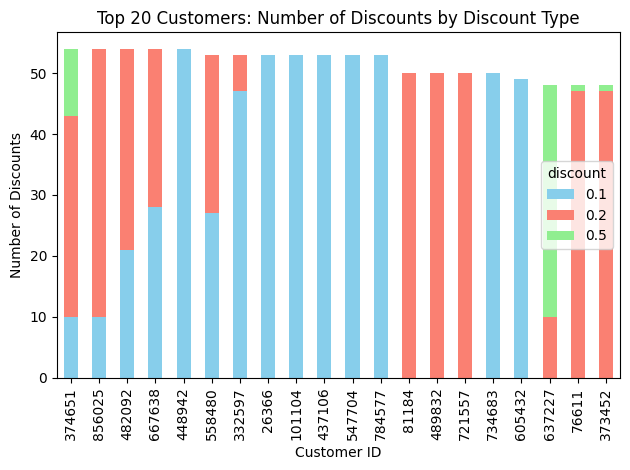

In [ ]:
# Pivot the DataFrame to have discount types as columns and customer_id as index
pivot_df = customer_discount_counts[customer_discount_counts['customer_id'].isin(top_20_customers['customer_id'])].pivot_table(
    index='customer_id', columns='discount', values='Number of Discounts', fill_value=0
)

# Reorder rows based on the index order of sorted_customers
pivot_df = pivot_df.loc[top_20_customers['customer_id']]

# Create a stacked bar chart with different colors for each discount type for the top 20 customers
plt.figure(figsize=(16, 6))
pivot_df.plot(kind='bar', stacked=True, color=['skyblue', 'salmon', 'lightgreen'])
plt.xlabel('Customer ID')
plt.ylabel('Number of Discounts')
plt.title('Top 20 Customers: Number of Discounts by Discount Type')
plt.tight_layout()
plt.show()
